# Compare long-term AusEFlux GPP with AusEFlux GPP v2.0


## Import libraries

In [1]:
import os
import pickle
import xarray as xr
import pandas as pd
import geopandas as gpd
import numpy as np
import xskillscore as xs
import contextily as ctx
from odc.geo.geom import Geometry
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('/g/data/xc0/project/AusEFlux/src/')
from _utils import round_coords

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Start dask client

In [2]:
from datacube.utils.dask import start_local_dask
client = start_local_dask(mem_safety_margin='2Gb')
client

distributed.nanny.memory - WARNING - Ignoring provided memory limit 538697001984 due to system memory limit of 124.00 GiB
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configurat

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 1
Total threads: 26,Total memory: 124.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46327,Workers: 1
Dashboard: /proxy/8787/status,Total threads: 26
Started: Just now,Total memory: 124.00 GiB
Comm: tcp://127.0.0.1:34487,Total threads: 26
Dashboard: /proxy/36309/status,Memory: 124.00 GiB
Nanny: tcp://127.0.0.1:45903,


In [3]:
var = 'GPP'

## Open version 2.0 & long-term GPP

In [4]:
# AusEFlux version 2.0
folder = f'/g/data/ub8/au/AusEFlux/v2/monthly/{var}'
files = [f'{folder}/{i}' for i in os.listdir(folder) if i.endswith(".nc")]
files.sort()
ds_v2 = xr.open_mfdataset(files).sel(time=slice('2003','2022'))#[f'{var}_median']
ds_v2 = assign_crs(ds_v2, crs='EPSG:4326')
ds_v2.attrs['nodata'] = np.nan

# Open long-term GPP v0.5
folder = f'/g/data/os22/chad_tmp/Aus_CO2_fertilisation/notebooks/upscale_GPP/results/AusEFlux/GPP'
files = [f'{folder}/{i}' for i in os.listdir(folder) if i.endswith(".nc")]
files.sort()
ds_v1 = xr.open_mfdataset(files).sel(time=slice('1982','2022')).compute()#[f'{var}_median']
ds_v1 = assign_crs(ds_v1, crs='EPSG:4326')
ds_v1.attrs['nodata'] = np.nan

# Open DIFFUSE-GPP and/or PML-GPP
path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/DIFFUSE_GPP_5km_2003_2021.nc'
# path = '/g/data/os22/chad_tmp/Aus_CO2_fertilisation/data/PML_GPP_5km_2001_2023.nc'
pml = assign_crs(xr.open_dataset(path), crs='EPSG:4326')
pml = pml.sel(time=slice('2003','2022'))

## Reproject to common grid

We'll use 5km to speed things up

In [5]:
# Grab a common grid to reproject too
gbox_path = f'/g/data/xc0/project/AusEFlux/data/grid_5km'
with open(gbox_path, 'rb') as f:
    gbox = pickle.load(f)

# ds_v1 = ds_v1.odc.reproject(how=gbox, resampling='bilinear').compute()
ds_v2 = ds_v2.odc.reproject(how=gbox, resampling='bilinear').compute()
ds_v2 = round_coords(ds_v2)

## Australia-wide time-series

In [6]:
# Long term per-pixel means
mean_v1= ds_v1.sel(time=slice('2003','2022')).mean('time')
mean_v2 = ds_v2.sel(time=slice('2003','2022')).mean('time')
mean_pml = pml.sel(time=slice('2003','2022')).mean('time')

#nan mask
mask = ~np.isnan(mean_v2[f'{var}_median'])

# Annual sum timeseries
annual_mean_v1 = ds_v1.resample(time='YE').sum().where(mask)
annual_mean_v2 = ds_v2.resample(time='YE').sum().where(mask)
annual_mean_pml = pml.resample(time='YE').sum().where(mask)

# long term annual per-pixel sum mean
summed_annual_v1 = annual_mean_v1[f'{var}_median'].sel(time=slice('2003','2022')).mean('time')
summed_annual_v2 = annual_mean_v2[f'{var}_median'].sel(time=slice('2003','2022')).mean('time')
summed_annual_pml = annual_mean_pml[f'{var}'].sel(time=slice('2003','2022')).mean('time')

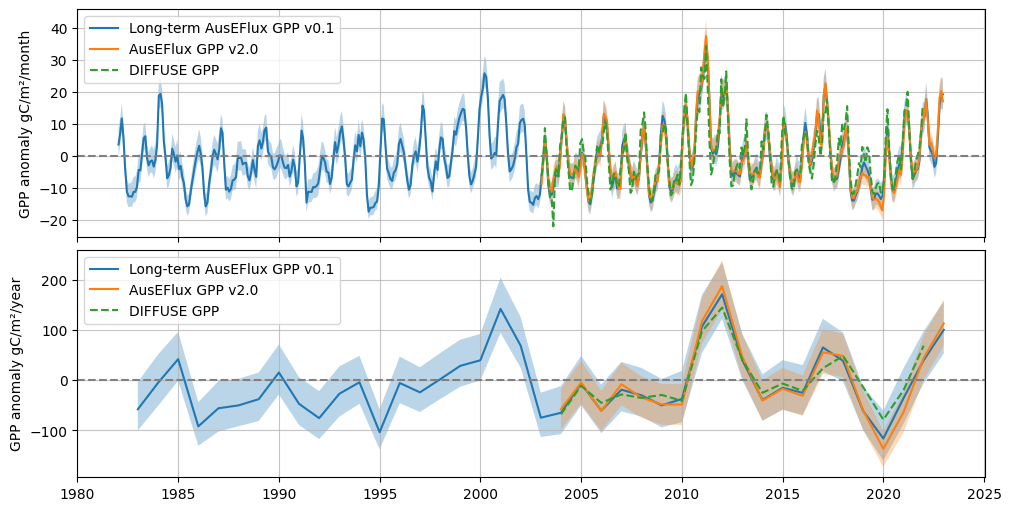

In [7]:
fig,ax=plt.subplots(2,1, figsize=(10,5), layout='constrained', sharex=True)

(ds_v1[f'{var}_median'] - mean_v1[f'{var}_median']).mean(['latitude', 'longitude']).plot(ax=ax[0], label=f'Long-term AusEFlux {var} v0.1')
upper_v1 = (ds_v1[f'{var}_25th_percentile'] - mean_v1[f'{var}_median']).mean(['latitude', 'longitude'])
lower_v1 = (ds_v1[f'{var}_75th_percentile'] - mean_v1[f'{var}_median']).mean(['latitude', 'longitude'])
ax[0].fill_between(ds_v1.time, lower_v1, upper_v1, alpha=0.3)

(ds_v2[f'{var}_median'] - mean_v2[f'{var}_median']).mean(['latitude', 'longitude']).plot(ax=ax[0], label=f'AusEFlux {var} v2.0')
upper_v2 = (ds_v2[f'{var}_25th_percentile'] - mean_v2[f'{var}_median']).mean(['latitude', 'longitude'])
lower_v2 = (ds_v2[f'{var}_75th_percentile'] - mean_v2[f'{var}_median']).mean(['latitude', 'longitude'])
ax[0].fill_between(ds_v2.time, lower_v2, upper_v2, alpha=0.3)

(pml[f'{var}'] - mean_pml[f'{var}']).mean(['latitude', 'longitude']).plot(ax=ax[0], label=f'DIFFUSE {var}', linestyle='--')
ax[0].axhline(0, linestyle='--', c='grey')

(annual_mean_v1[f'{var}_median'] - summed_annual_v1).mean(['latitude', 'longitude']).plot(ax=ax[1], label=f'Long-term AusEFlux {var} v0.1')
upper_v1 = (annual_mean_v1[f'{var}_25th_percentile']- summed_annual_v1).mean(['latitude', 'longitude'])
lower_v1 = (annual_mean_v1[f'{var}_75th_percentile']- summed_annual_v1).mean(['latitude', 'longitude'])
ax[1].fill_between(annual_mean_v1.time, lower_v1, upper_v1, alpha=0.3)

(annual_mean_v2[f'{var}_median'] - summed_annual_v2).mean(['latitude', 'longitude']).plot(ax=ax[1], label=f'AusEFlux {var} v2.0')
upper_v2 = (annual_mean_v2[f'{var}_25th_percentile']- summed_annual_v2).mean(['latitude', 'longitude'])
lower_v2 = (annual_mean_v2[f'{var}_75th_percentile']- summed_annual_v2).mean(['latitude', 'longitude'])
ax[1].fill_between(annual_mean_v2.time, lower_v2, upper_v2, alpha=0.3)

(annual_mean_pml[f'{var}'] - summed_annual_pml).mean(['latitude', 'longitude']).plot(ax=ax[1], label=f'DIFFUSE {var}', linestyle='--')
ax[1].axhline(0, linestyle='--', c='grey')

ax[0].grid(alpha=0.75)
ax[1].grid(alpha=0.75)
ax[0].set_ylabel('GPP anomaly gC/m\N{SUPERSCRIPT TWO}/month')
ax[1].set_ylabel('GPP anomaly gC/m\N{SUPERSCRIPT TWO}/year')
ax[0].set_xlabel(None)
ax[0].set_title(None)
ax[1].set_title(None)
ax[1].set_xlabel(None)
ax[0].legend()
ax[1].legend();

## Per pixel comparison

In [8]:
corr = xr.corr(ds_v2[f'{var}_median'].sel(time=slice('2003','2022')),
               ds_v1[f'{var}_median'].sel(time=slice('2003','2022')), dim='time').rename('Pearson Correlation')

cv = xs.rmse(ds_v2[f'{var}_median'].sel(time=slice('2003','2022')),
             ds_v1[f'{var}_median'].sel(time=slice('2003','2022')), dim='time', skipna=True).rename('CV')
cv = cv/annual_mean_v2[f'{var}_median'].mean('time')

corr_data = [summed_annual_v1,
             summed_annual_v2,
             cv,
             corr]

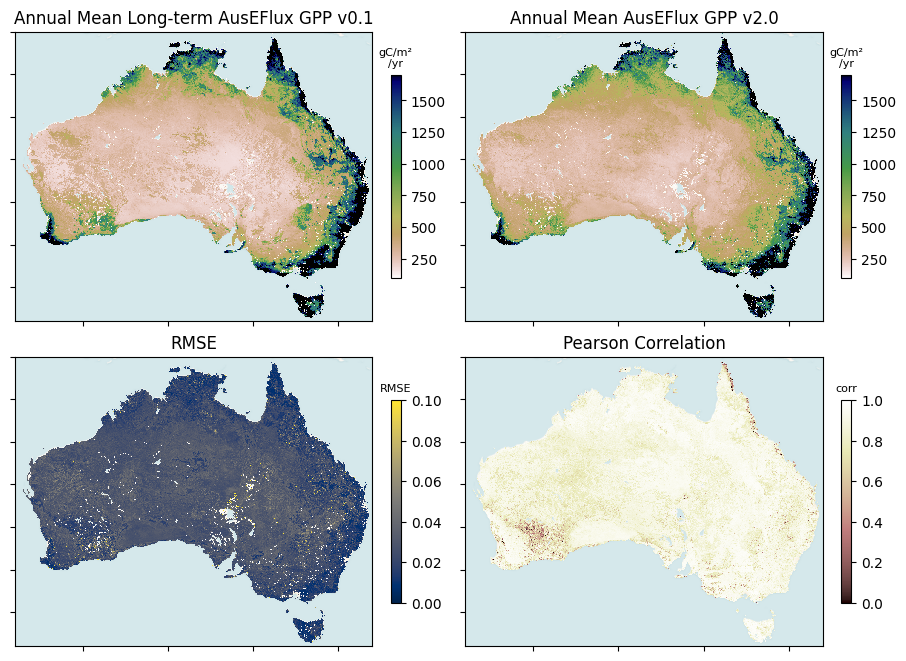

In [9]:
products=[f'Annual Mean Long-term AusEFlux {var} v0.1', f'Annual Mean AusEFlux {var} v2.0', 
          'RMSE', 'Pearson Correlation']
cmaps = ['gist_earth_r', 'gist_earth_r', 'cividis', 'pink']

fig,axes = plt.subplots(2,2, figsize=(9,6.5), sharey=True, sharex=True, layout='constrained')

for ax, ds, n, cmap in zip(axes.ravel(), corr_data, products, cmaps):
    if cmap=='pink':
        vmin=0
        vmax=1.0
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        title='corr'

    if cmap=='cividis':
        vmin = 0
        vmax = 0.1
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        title='RMSE'

    if cmap=='gist_earth_r':
        vmin=100
        vmax=1700
        im = ds.plot(vmin=vmin, vmax=vmax, cmap=cmap, ax=ax, add_colorbar=False)
        title='gC/m\N{SUPERSCRIPT TWO}\n/yr'

    cbar = plt.colorbar(im, ax=ax, shrink=0.7)
    cbar.ax.set_title(title, fontsize=8)
    # cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.set_title(f'{n}')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    ax.set_xticklabels([])


## Seasonal cycles

In [10]:
#calculate climatology
clim_v1 = ds_v1.sel(time=slice('2003','2022')).groupby('time.month').mean()
clim_v2 = ds_v2.sel(time=slice('2003','2022')).groupby('time.month').mean()
clim_pml = pml.sel(time=slice('2003','2022')).groupby('time.month').mean()

### Aus-wide seasonal cycle

We will also open and plot bioclimatic regions alongside so the regions are obvious for the subsequent plots

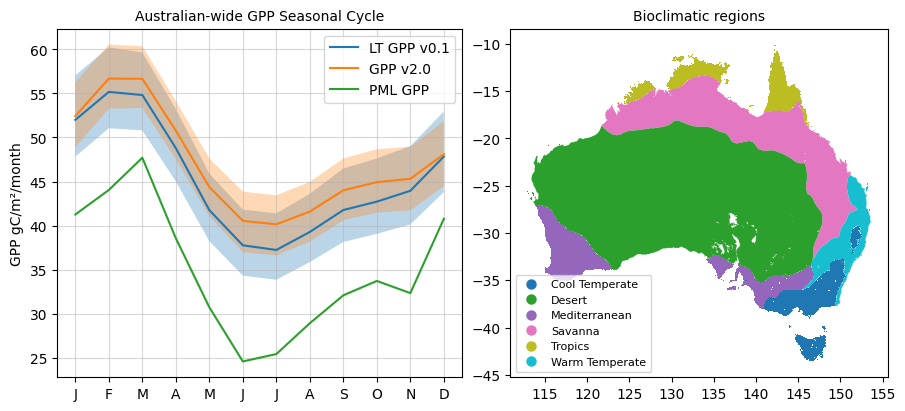

In [11]:
gdf = gpd.read_file('/g/data/xc0/project/AusEFlux/data/bioclim_regions.geojson')

fig, ax = plt.subplots(1,2, figsize=(9,4), layout='constrained')

clim_v1_1D = clim_v1.mean(['latitude', 'longitude'])
clim_v2_1D = clim_v2.mean(['latitude', 'longitude'])
clim_pml_1D = clim_pml.mean(['latitude', 'longitude'])

clim_v1_1D[f'{var}_median'].plot(linestyle='-', ax=ax[0], label=f'LT {var} v0.1', c='tab:blue')
ax[0].fill_between(clim_v1_1D.month, clim_v1_1D[f'{var}_25th_percentile'],
                clim_v1_1D[f'{var}_75th_percentile'], alpha=0.3)

clim_v2_1D[f'{var}_median'].plot(linestyle='-', ax=ax[0], label=f'{var} v2.0', c='tab:orange')
ax[0].fill_between(clim_v2_1D.month, clim_v2_1D[f'{var}_25th_percentile'],
                clim_v2_1D[f'{var}_75th_percentile'], alpha=0.3)

clim_pml_1D[f'{var}'].plot(linestyle='-', ax=ax[0], label=f'PML {var}', c='tab:green')

if var=='NEE':
    ax.axhline(0, c='grey', linestyle='--')
ax[0].set_title(f'Australian-wide {var} Seasonal Cycle', fontdict={'fontsize': 10})
ax[0].set_ylabel('GPP gC/m\N{SUPERSCRIPT TWO}/month')
ax[0].set_xlabel('')
ax[0].grid(alpha=0.5)
ax[0].set_xticks(range(1,13))
ax[0].legend()
ax[0].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 

gdf.plot(column='region_name', legend=True, figsize=(5,4), ax=ax[1],legend_kwds={'loc':'lower left', 'ncols':1, 'fontsize':8, 'markerscale':0.75} )
ax[1].set_title(f'Bioclimatic regions', fontdict={'fontsize': 10});

###  Seasonal cycle per bioregion

In [12]:
# Dictionary to save results 
results_v1 = {}
results_v2 = {}
results_pml = {}
for index, row in gdf.iterrows():
    # Generate a polygon mask to keep only data within the polygon
    geom = Geometry(geom=gdf.iloc[index].geometry, crs=gdf.crs)
    dss_v1 = clim_v1.odc.mask(poly=geom)
    dss_v2 = clim_v2.odc.mask(poly=geom)
    dss_pml = clim_pml.odc.mask(poly=geom)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results_v1.update({row['region_name']: dss_v1})
    results_v2.update({row['region_name']: dss_v2})
    results_pml.update({row['region_name']: dss_pml})

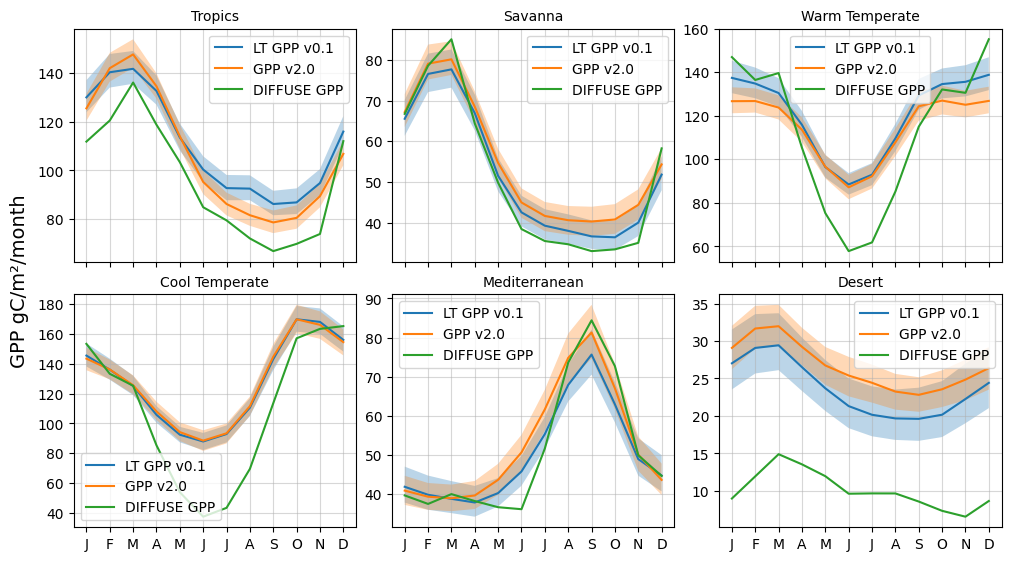

In [13]:
fig, axs = plt.subplots(2,3, figsize=(10,5.5), sharex=True, layout='constrained')

for ax, k in zip(axs.ravel(), results_v1.keys()):
    
    _1D_v1 = results_v1[k].mean(['latitude', 'longitude'])
    _1D_v2 = results_v2[k].mean(['latitude', 'longitude'])
    _1D_pml = results_pml[k].mean(['latitude', 'longitude'])
    
    _1D_v1[f'{var}_median'].plot(linestyle='-', ax=ax, label=f'LT {var} v0.1', c='tab:blue')
    ax.fill_between(_1D_v1.month, _1D_v1[f'{var}_25th_percentile'],
                    _1D_v1[f'{var}_75th_percentile'], alpha=0.3)
    
    _1D_v2[f'{var}_median'].plot(linestyle='-', ax=ax, label=f'{var} v2.0', c='tab:orange')
    ax.fill_between(_1D_v2.month, _1D_v2[f'{var}_25th_percentile'],
                    _1D_v2[f'{var}_75th_percentile'], alpha=0.3)

    _1D_pml[f'{var}'].plot(linestyle='-', ax=ax, label=f'DIFFUSE {var}', c='tab:green')

    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 10})
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(alpha=0.5)
    ax.set_xticks(range(1,13))
    ax.legend()
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 

fig.supylabel('GPP gC/m\N{SUPERSCRIPT TWO}/month', fontsize=14);

## Trends

In [14]:
trends_v1 = annual_mean_v1[f'{var}_median'].sel(time=slice('2003','2022')).groupby('time.year').mean().polyfit('year', deg=1)['polyfit_coefficients']
trends_v2 = annual_mean_v2[f'{var}_median'].sel(time=slice('2003','2022')).groupby('time.year').mean().polyfit('year', deg=1)['polyfit_coefficients']

## Mega plot for thesis

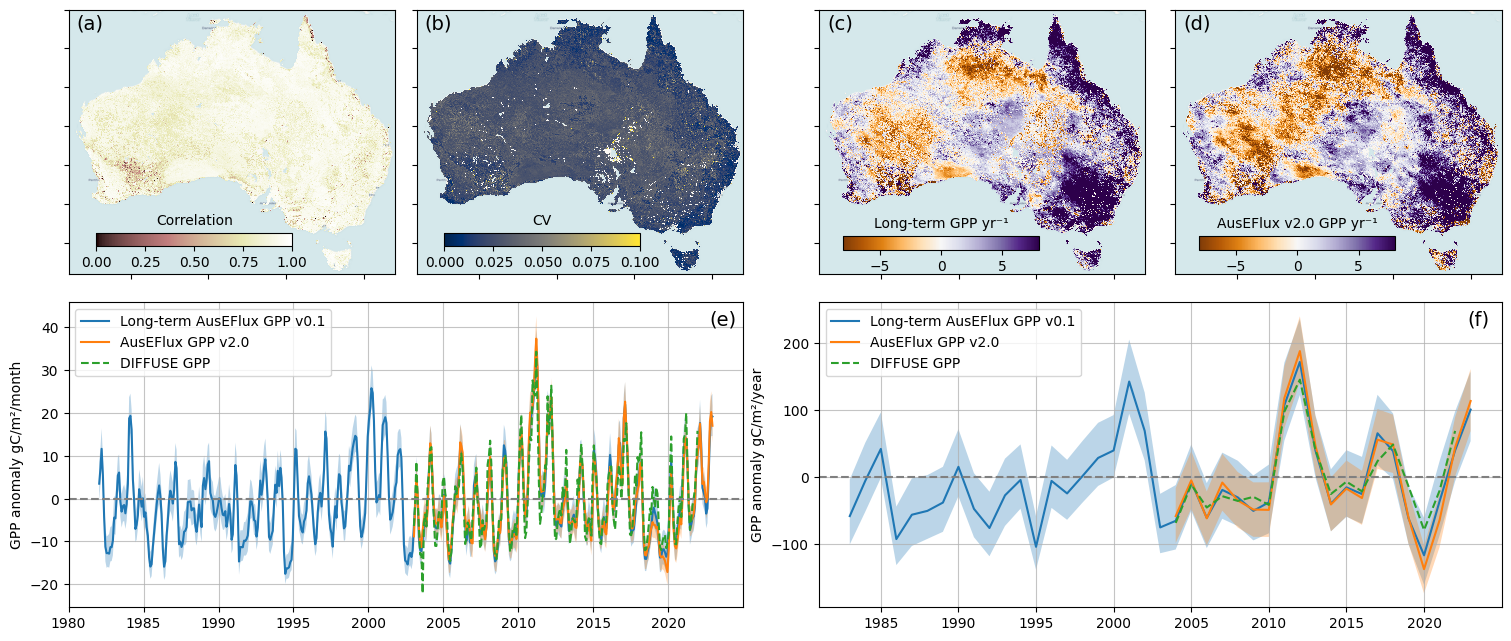

In [15]:
layout = [
    ['A',  'B',  'C', 'D'],
    ['E','E', 'F', 'F']
]

# Create the mosaic plot
fig, axes = plt.subplot_mosaic(layout, figsize=(15, 6.5), layout='constrained')

im = corr.plot(vmin=0, vmax=1.0, cmap='pink', ax=axes['A'], add_colorbar=False, add_labels=False)
ctx.add_basemap(axes['A'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(axes['A'],width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title('Correlation', fontsize=10)
axes['A'].set_yticklabels([])
axes['A'].set_xticklabels([])

im = cv.plot(vmin=0, vmax=0.10, cmap='cividis', ax=axes['B'], add_colorbar=False, add_labels=False)
ctx.add_basemap(axes['B'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(axes['B'],width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title('CV', fontsize=10)
axes['B'].set_yticklabels([])
axes['B'].set_xticklabels([])

im = trends_v1.sel(degree=1).plot(ax=axes['C'], cmap='PuOr', vmin=-8, vmax=8, add_colorbar=False, add_labels=False)
ctx.add_basemap(axes['C'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(axes['C'],width="60%",height="5%",loc="lower left", borderpad=1.75)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title('Long-term GPP yr\u207B\u00B9', fontsize=10)
axes['C'].set_yticklabels([])
axes['C'].set_xticklabels([])

im = trends_v2.sel(degree=1).plot(ax=axes['D'], cmap='PuOr', vmin=-8, vmax=8, add_colorbar=False, add_labels=False)
ctx.add_basemap(axes['D'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(axes['D'],width="60%",height="5%",loc="lower left", borderpad=1.75)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title('AusEFlux v2.0 GPP yr\u207B\u00B9', fontsize=10)
axes['D'].set_yticklabels([])
axes['D'].set_xticklabels([])

(ds_v1[f'{var}_median'] - mean_v1[f'{var}_median']).mean(['latitude', 'longitude']).plot(ax=axes['E'], label=f'Long-term AusEFlux {var} v0.1')
upper_v1 = (ds_v1[f'{var}_25th_percentile'] - mean_v1[f'{var}_median']).mean(['latitude', 'longitude'])
lower_v1 = (ds_v1[f'{var}_75th_percentile'] - mean_v1[f'{var}_median']).mean(['latitude', 'longitude'])
axes['E'].fill_between(ds_v1.time, lower_v1, upper_v1, alpha=0.3)

(ds_v2[f'{var}_median'] - mean_v2[f'{var}_median']).mean(['latitude', 'longitude']).plot(ax=axes['E'], label=f'AusEFlux {var} v2.0')
upper_v2 = (ds_v2[f'{var}_25th_percentile'] - mean_v2[f'{var}_median']).mean(['latitude', 'longitude'])
lower_v2 = (ds_v2[f'{var}_75th_percentile'] - mean_v2[f'{var}_median']).mean(['latitude', 'longitude'])
axes['E'].fill_between(ds_v2.time, lower_v2, upper_v2, alpha=0.3)

(pml[f'{var}'] - mean_pml[f'{var}']).mean(['latitude', 'longitude']).plot(ax=axes['E'], label=f'DIFFUSE {var}', linestyle='--')
axes['E'].axhline(0, linestyle='--', c='grey')

(annual_mean_v1[f'{var}_median'] - summed_annual_v1).mean(['latitude', 'longitude']).plot(ax=axes['F'], label=f'Long-term AusEFlux {var} v0.1')
upper_v1 = (annual_mean_v1[f'{var}_25th_percentile']- summed_annual_v1).mean(['latitude', 'longitude'])
lower_v1 = (annual_mean_v1[f'{var}_75th_percentile']- summed_annual_v1).mean(['latitude', 'longitude'])
axes['F'].fill_between(annual_mean_v1.time, lower_v1, upper_v1, alpha=0.3)

(annual_mean_v2[f'{var}_median'] - summed_annual_v2).mean(['latitude', 'longitude']).plot(ax=axes['F'], label=f'AusEFlux {var} v2.0')
upper_v2 = (annual_mean_v2[f'{var}_25th_percentile']- summed_annual_v2).mean(['latitude', 'longitude'])
lower_v2 = (annual_mean_v2[f'{var}_75th_percentile']- summed_annual_v2).mean(['latitude', 'longitude'])
axes['F'].fill_between(annual_mean_v2.time, lower_v2, upper_v2, alpha=0.3)

(annual_mean_pml[f'{var}'] - summed_annual_pml).mean(['latitude', 'longitude']).plot(ax=axes['F'], label=f'DIFFUSE {var}', linestyle='--')
axes['F'].axhline(0, linestyle='--', c='grey')

axes['E'].set_title(None)
axes['F'].set_title(None)
axes['E'].grid(alpha=0.75)
axes['F'].grid(alpha=0.75)
axes['E'].set_ylabel('GPP anomaly gC/m\N{SUPERSCRIPT TWO}/month')
axes['F'].set_ylabel('GPP anomaly gC/m\N{SUPERSCRIPT TWO}/year')
axes['E'].set_xlabel(None)
axes['F'].set_xlabel(None)
axes['E'].legend()
axes['F'].legend();

axes['A'].text(0.025, 0.925, f'(a)',  transform=axes['A'].transAxes, fontsize=14)
axes['B'].text(0.025, 0.925, f'(b)',  transform=axes['B'].transAxes, fontsize=14)
axes['C'].text(0.025, 0.925, f'(c)',  transform=axes['C'].transAxes, fontsize=14)
axes['D'].text(0.025, 0.925, f'(d)',  transform=axes['D'].transAxes, fontsize=14)
axes['E'].text(0.95, 0.925, f'(e)',  transform=axes['E'].transAxes, fontsize=14)
axes['F'].text(0.95, 0.925, f'(f)',  transform=axes['F'].transAxes, fontsize=14);

fig.savefig("/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/AusEFlux_GPP_compare_mega_plot.png",
            bbox_inches='tight', dpi=300)

## Alternate megaplot

In [16]:
trends_v1 = annual_mean_v1[f'{var}_median'].sel(time=slice('2003','2021')).groupby('time.year').mean().polyfit('year', deg=1)['polyfit_coefficients']
trends_v2 = annual_mean_v2[f'{var}_median'].sel(time=slice('2003','2021')).groupby('time.year').mean().polyfit('year', deg=1)['polyfit_coefficients']
trends_pml = annual_mean_pml[f'{var}'].sel(time=slice('2003','2021')).groupby('time.year').mean().polyfit('year', deg=1)['polyfit_coefficients']

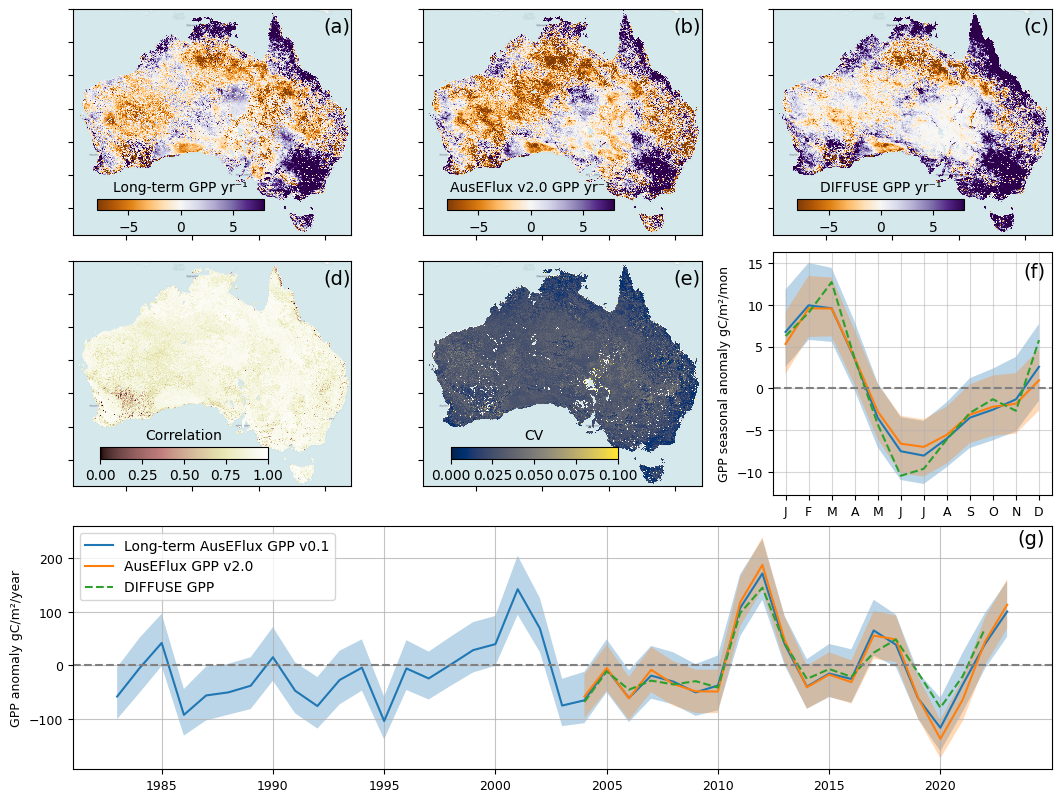

In [55]:
layout = [
    ['A','B','C'],
    ['D','E','F'],
    ['G','G','G']
]

# Create the mosaic plot
fig, axes = plt.subplot_mosaic(layout, figsize=(10.5,8), layout='constrained')

#------Linear trends------------------------------------------------------------
im = trends_v1.sel(degree=1).plot(ax=axes['A'], cmap='PuOr', vmin=-8, vmax=8, add_colorbar=False, add_labels=False)
ctx.add_basemap(axes['A'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(axes['A'],width="60%",height="5%",loc="lower left", borderpad=1.75)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title('Long-term GPP yr\u207B\u00B9', fontsize=10)
axes['A'].set_yticklabels([])
axes['A'].set_xticklabels([])

im = trends_v2.sel(degree=1).plot(ax=axes['B'], cmap='PuOr', vmin=-8, vmax=8, add_colorbar=False, add_labels=False)
ctx.add_basemap(axes['B'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(axes['B'],width="60%",height="5%",loc="lower left", borderpad=1.75)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title('AusEFlux v2.0 GPP yr\u207B\u00B9', fontsize=10)
axes['B'].set_yticklabels([])
axes['B'].set_xticklabels([])

im = trends_pml.sel(degree=1).plot(ax=axes['C'], cmap='PuOr', vmin=-8, vmax=8, add_colorbar=False, add_labels=False)
ctx.add_basemap(axes['C'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(axes['C'],width="60%",height="5%",loc="lower left", borderpad=1.75)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title('DIFFUSE GPP yr\u207B\u00B9', fontsize=10)
axes['C'].set_yticklabels([])
axes['C'].set_xticklabels([])

##--------Correlation and deviation------------------------------------
im = corr.plot(vmin=0, vmax=1.0, cmap='pink', ax=axes['D'], add_colorbar=False, add_labels=False)
ctx.add_basemap(axes['D'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(axes['D'],width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title('Correlation', fontsize=10)
axes['D'].set_yticklabels([])
axes['D'].set_xticklabels([])

im = cv.plot(vmin=0, vmax=0.10, cmap='cividis', ax=axes['E'], add_colorbar=False, add_labels=False)
ctx.add_basemap(axes['E'], source=ctx.providers.CartoDB.Voyager, crs='EPSG:4326', attribution='', attribution_size=1)
axins1 = inset_axes(axes['E'],width="60%",height="5%",loc="lower left", borderpad=2)
cbar = fig.colorbar(im, cax=axins1,orientation='horizontal')
cbar.ax.set_title('CV', fontsize=10)
axes['E'].set_yticklabels([])
axes['E'].set_xticklabels([])

#------Seasonal cycle----------------------------------
(clim_v1_1D[f'{var}_median'] - clim_v1_1D[f'{var}_median'].mean()).plot(linestyle='-', ax=axes['F'], label=f'LT {var} v0.1', c='tab:blue')
upper_clim_v1 = clim_v1_1D[f'{var}_25th_percentile'] - clim_v1_1D[f'{var}_median'].mean()
lower_clim_v1 = clim_v1_1D[f'{var}_75th_percentile'] - clim_v1_1D[f'{var}_median'].mean()
axes['F'].fill_between(clim_v1_1D.month, lower_clim_v1, upper_clim_v1, alpha=0.3)

(clim_v2_1D[f'{var}_median'] - clim_v2_1D[f'{var}_median'].mean()).plot(linestyle='-', ax=axes['F'], label=f'{var} v2.0', c='tab:orange')
upper_clim_v2 = clim_v2_1D[f'{var}_25th_percentile'] - clim_v2_1D[f'{var}_median'].mean()
lower_clim_v2 = clim_v2_1D[f'{var}_75th_percentile'] - clim_v2_1D[f'{var}_median'].mean()
axes['F'].fill_between(clim_v1_1D.month, lower_clim_v2, upper_clim_v2, alpha=0.3)

(clim_pml_1D[f'{var}'] - clim_pml_1D[f'{var}'].mean()).plot(linestyle='--', ax=axes['F'], label=f'DIFFUSE {var}', c='tab:green')

axes['F'].set_title(None)
axes['F'].set_ylabel('GPP seasonal anomaly gC/m\N{SUPERSCRIPT TWO}/mon', fontsize=9)
axes['F'].set_xlabel('')
axes['F'].grid(alpha=0.5)
axes['F'].set_xticks(range(1,13))
axes['F'].tick_params(axis='both', which='major', labelsize=9)
axes['F'].set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=9) 

##------aggreagted annual mean time series-------------------------------------

(annual_mean_v1[f'{var}_median'] - summed_annual_v1).mean(['latitude', 'longitude']).plot(ax=axes['G'], label=f'Long-term AusEFlux {var} v0.1')
upper_v1 = (annual_mean_v1[f'{var}_25th_percentile']- summed_annual_v1).mean(['latitude', 'longitude'])
lower_v1 = (annual_mean_v1[f'{var}_75th_percentile']- summed_annual_v1).mean(['latitude', 'longitude'])
axes['G'].fill_between(annual_mean_v1.time, lower_v1, upper_v1, alpha=0.3)

(annual_mean_v2[f'{var}_median'] - summed_annual_v2).mean(['latitude', 'longitude']).plot(ax=axes['G'], label=f'AusEFlux {var} v2.0')
upper_v2 = (annual_mean_v2[f'{var}_25th_percentile']- summed_annual_v2).mean(['latitude', 'longitude'])
lower_v2 = (annual_mean_v2[f'{var}_75th_percentile']- summed_annual_v2).mean(['latitude', 'longitude'])
axes['G'].fill_between(annual_mean_v2.time, lower_v2, upper_v2, alpha=0.3)

(annual_mean_pml[f'{var}'] - summed_annual_pml).mean(['latitude', 'longitude']).plot(ax=axes['G'], label=f'DIFFUSE {var}', linestyle='--')

#-----Plot elements--------------------------------
axes['G'].axhline(0, linestyle='--', c='grey')
axes['F'].axhline(0, linestyle='--', c='grey')
axes['D'].set_title(None)
axes['E'].set_title(None)
axes['G'].set_title(None)
axes['G'].tick_params(axis='both', which='major', labelsize=9)
axes['G'].grid(alpha=0.75)
axes['G'].set_ylabel('GPP anomaly gC/m\N{SUPERSCRIPT TWO}/year', fontsize=9)
axes['D'].set_xlabel(None)
axes['E'].set_xlabel(None)
axes['G'].legend(loc='upper left')
axes['G'].set_xlabel(None)

axes['A'].text(0.90, 0.90, f'(a)',  transform=axes['A'].transAxes, fontsize=14)
axes['B'].text(0.90, 0.90, f'(b)',  transform=axes['B'].transAxes, fontsize=14)
axes['C'].text(0.90, 0.90, f'(c)',  transform=axes['C'].transAxes, fontsize=14)
axes['D'].text(0.9, 0.90, f'(d)',  transform=axes['D'].transAxes, fontsize=14)
axes['E'].text(0.9, 0.90, f'(e)',  transform=axes['E'].transAxes, fontsize=14)
axes['F'].text(0.9, 0.90, f'(f)',  transform=axes['F'].transAxes, fontsize=14)
axes['G'].text(0.965, 0.925, f'(g)',  transform=axes['G'].transAxes, fontsize=14);

fig.savefig("/g/data/os22/chad_tmp/Aus_CO2_fertilisation/results/figs/AusEFlux_GPP_compare_mega_plot1.png",
            bbox_inches='tight', dpi=300)